# Introduction


## 1.1 Some Apparently Simple Questions

## 1.2 An Alternative Analytic Framework

Solved to a high degree of accuracy using numerical method

In [1]:
!pip install --user quantecon

The directory '/home/jovyan/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/jovyan/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


In [15]:
import numpy as np
import numpy.linalg as la
from numba import *
from __future__ import division
#from quantecon.quad import qnwnorm



Suppose now that the economist is presented with a  demand function

$$q = 0.5* p^{-0.2} + 0.5*p^{-0.5}$$

one that is the sum a domestic demand term and an export demand term.

suppose that the economist is asked to find the price that clears the
market of, say, a quantity of 2 units.




In [9]:
#%pylab inline
%pylab notebook
# pylab Populating the interactive namespace from numpy and matplotlib
# numpy for numerical computation
# matplotlib for ploting

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


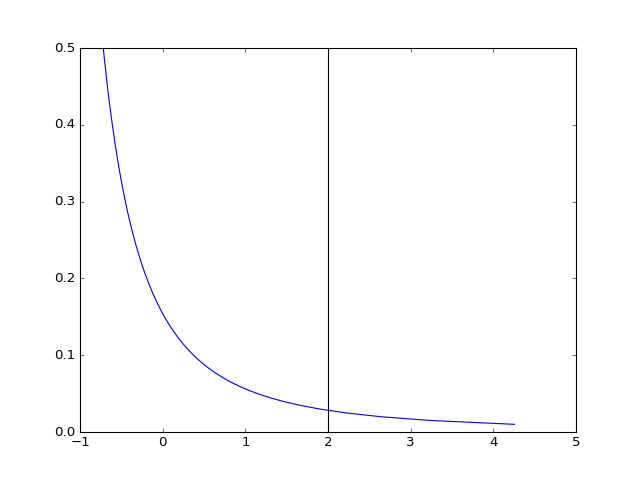

In [10]:
#http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot
p = np.linspace(0.01,0.5, 100)
q = .5 * p **-.2 + .5 * p ** -.5 - 2
plot(q,p)
x1,x2,y1,y2 = 2, 2, 0, 0.5
plot((x1, x2), (y1, y2), 'k-')

In [11]:
# example 1.2

p = 0.25
for i in range(100):
    deltap = (.5 * p **-.2 + .5 * p ** -.5 - 2)/(.1 * p **-1.2 + .25 * p **-1.5)
    p = p + deltap
    if abs(deltap) < 1.e-8: #  accuracy
        break
#https://stackoverflow.com/questions/20457038/python-how-to-round-down-to-2-decimals
print('The market clean price is {:0.2f} '.format(p))


The market clean price is 0.15 


Consider now the rational expectations commodity market model with government
intervention. The source of difficulty in solving this problem is the need to
evaluate the truncated expectation of a continuous distribution.

The economist would replace the original normal yield distribution
with a discrete distribution that has identical lower moments, say one that assumes
values y1; y2; ... ; yn with probabilities w1; w2; ...; wn.

In [12]:
# https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/quad.py
def qnwnorm(n, mu=None, sig2=None, usesqrtm=False):
    """
    Computes nodes and weights for multivariate normal distribution
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    mu : scalar or array_like(float), optional(default=zeros(d))
        The means of each dimension of the random variable. If a scalar
        is given, that constant is repeated d times, where d is the
        number of dimensions
    sig2 : array_like(float), optional(default=eye(d))
        A d x d array representing the variance-covariance matrix of the
        multivariate normal distribution.
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwnorm`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    n = np.asarray(n)
    d = n.size

    if mu is None:
        mu = np.zeros((d,1))
    else:
        mu = np.asarray(mu).reshape(-1, 1)

    if sig2 is None:
        sig2 = np.eye(d)
    else:
        sig2 = np.asarray(sig2).reshape(d, d)

    if all([x.size == 1 for x in [n, mu, sig2]]):
        nodes, weights = _qnwnorm1(n)
    else:
        nodes = []
        weights = []

        for i in range(d):
            _1d = _qnwnorm1(n[i])
            nodes.append(_1d[0])
            weights.append(_1d[1])

        nodes = gridmake(*nodes)
        weights = ckron(*weights[::-1])

    if usesqrtm:
        new_sig2 = la.sqrtm(sig2)
    else:  # cholesky
        new_sig2 = la.cholesky(sig2)

    if d > 1:
        nodes = new_sig2.dot(nodes) + mu  # Broadcast ok
    else:  # nodes.dot(sig) will not be aligned in scalar case.
        nodes = nodes * new_sig2 + mu

    return nodes.squeeze(), weights



def _qnwnorm1(n):
    """
    Compute nodes and weights for quadrature of univariate standard
    normal distribution
    Parameters
    ----------
    n : int
        The number of nodes
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwnorm1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    maxit = 100
    pim4 = 1 / np.pi**(0.25)
    m = np.fix((n + 1) / 2).astype(int)
    nodes = np.zeros(n)
    weights = np.zeros(n)

    for i in range(m):
        if i == 0:
            z = np.sqrt(2*n+1) - 1.85575 * ((2 * n + 1)**(-1 / 6.1))
        elif i == 1:
            z = z - 1.14 * (n ** 0.426) / z
        elif i == 2:
            z = 1.86 * z + 0.86 * nodes[0]
        elif i == 3:
            z = 1.91 * z + 0.91 * nodes[1]
        else:
            z = 2 * z + nodes[i-2]

        its = 0

        while its < maxit:
            its += 1
            p1 = pim4
            p2 = 0
            for j in range(1, n+1):
                p3 = p2
                p2 = p1
                p1 = z * math.sqrt(2.0/j) * p2 - math.sqrt((j - 1.0) / j) * p3

            pp = math.sqrt(2 * n) * p2
            z1 = z
            z = z1 - p1/pp
            if abs(z - z1) < 1e-14:
                break

        if its == maxit:
            raise ValueError("Failed to converge in _qnwnorm1")

        nodes[n - 1 - i] = z
        nodes[i] = -z
        weights[i] = 2 / (pp*pp)
        weights[n - 1 - i] = weights[i]

    weights /= math.sqrt(math.pi)
    nodes = nodes * math.sqrt(2.0)

    return nodes, weights


In [16]:
# example 1.2

y, w = qnwnorm(10, 1, 0.1)
a = 1
for it in range(100):
    aold = a
    p = 3 - 2 * a * y
    f = w.dot(np.maximum(p, 1))
    a = 0.5 + 0.5 * f
    if abs(a - aold) < 1.e-8:
        break

print('The rational expectations equilibrium acreage is {:0.2f} '.format(a) )
print('The expected market price is {:0.2f} '.format(np.dot(w, p)) )
print('The expected effective producer price is {:0.2f} '.format(f) )



The rational expectations equilibrium acreage is 1.10 
The expected market price is 0.81 
The expected effective producer price is 1.19 


The economist has combined Gaussian quadrature techniques and fixed-point function iteration methods to solve the problem.